In [2]:
import os
import glob
import random
from collections import OrderedDict
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2

import torch
import torch.nn as nn
import torch.nn.modules.conv as conv
import torch.utils.data as utils
import torch.nn.functional as F
from torch.nn import Parameter
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from faker import Faker

from collections import namedtuple
import torch.nn.init as init
from torchvision import models
from torchvision.models.vgg import model_urls

In [5]:
im = Image.open("/notebooks/CoordConv-pytorch/data/facebook/680366_556253391067641_2056418463_o.jpg")
im.mode

'RGB'

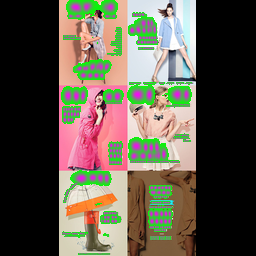

In [54]:
class MyDataset(Dataset):
    def __init__(self, img_size):
        self.post_folder = "/notebooks/CRAFT-pytorch/data"
        self.mask_folder = "/notebooks/CRAFT-pytorch/result"
        self.photo_folder = "/notebooks/CoordConv-pytorch/data/facebook"
#         self.post_folder = "/tf/CRAFT-pytorch/data"
#         self.mask_folder = "/tf/CRAFT-pytorch/result"
#         self.photo_folder = "/tf/CoordConv/data/facebook"

        norm_mean = np.array([0.5, 0.5, 0.5])
        norm_sigma = np.array([0.5, 0.5, 0.5])
        trans_rgb = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(norm_mean, norm_sigma),
            ]
        )    
        trans_pil = transforms.Compose(
            [
                transforms.Normalize(-(norm_mean/norm_sigma), 1 / norm_sigma),  # inverse-normalize
                transforms.ToPILImage()
            ]
        )    
        trans_l = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ]
        )

        self.font = "/notebooks/post-generator/asset/fonts_en/Roboto/Roboto-Regular.ttf"
        self.font_size = 14
        self.out_size = 14
        self.max_chars = 10

        self.img_size = img_size
        self.posts = glob.glob(self.post_folder + "/*.jpg")
        self.photos = glob.glob(self.photo_folder + "/*.jpg")

    def __getitem__(self, index):
        f = self.posts[index]
        post = Image.open(f)
        post = self._resize(post, self.img_size)
        mask = Image.open(
            os.path.join(
                self.mask_folder, os.path.splitext(os.path.basename(f))[0] + "_mask.png"
            )
        )
        mask = self._resize(mask, self.img_size)
        heat = self._heatmap(post, mask)
        photo = Image.open(random.choice(self.photos))
        photo = self._resize(photo, self.img_size * 2)

#         return photo, mask, heat
#         return self.transform(mask), self.transform(photo)

    def __len__(self):
        return len(self.posts)
    
    def _heatmap(self, img, mask):
#         photo = Image.open("/notebooks/CRAFT-pytorch/data/0ab11d92dc2e59e3e41eb6b9374098a5.jpg")
#         mask = Image.open("/notebooks/CRAFT-pytorch/result/0ab11d92dc2e59e3e41eb6b9374098a5_mask.png")
        img = trans_rgb(img)
        mask = trans_l(mask)

        heat = mask.repeat([3,1,1])  # (1, H, W) to (3, H, W)
        heat = heat.permute(1, 2, 0)  # (H, W, C)
        heat = torch.mul(heat, torch.tensor([[1., -1., 1.]]))  # map color
        heat = heat.permute(2, 0, 1)  # (C, H, W)
        mask = (mask > -0.95).float()  # convert to binary
        heat = (1. - mask) * photo + mask * heat
        
        return heat
#         heat = np.array(mask)
#         heat = np.expand_dims(heat, axis=-1)
#         heat = np.repeat(heat, 3, axis=-1)
#         heat[:,:,1] = 1 - heat[:,:,1]  # color transform

#         img.putalpha(255)
#         heat = Image.fromarray(heat)
#         heat.putalpha(mask.point(lambda x: 0 if x < 30 else 255))
#         return Image.alpha_composite(img, heat)
        pass

    def _heatmap_deprecated(self, img, mask):
        heat = np.array(mask)
        heat = np.expand_dims(heat, axis=-1)
        heat = np.repeat(heat, 3, axis=-1)
        heat[:,:,1] = 1 - heat[:,:,1]  # color transform

        img.putalpha(255)
        heat = Image.fromarray(heat)
        heat.putalpha(mask.point(lambda x: 0 if x < 30 else 255))
        return Image.alpha_composite(img, heat)

    def _resize(self, img, out_size):
        size = img.size  # old_size[0] is in (width, height) format
        ratio = float(out_size) / max(size)
        new_size = tuple(int(x * ratio) for x in size)
        img = img.resize(new_size, Image.ANTIALIAS)
        res = Image.new(img.mode, (out_size, out_size))
        res.paste(img, ((out_size - new_size[0]) // 2, (out_size - new_size[1]) // 2))
        return res

norm_mean = np.array([0.5, 0.5, 0.5])
norm_sigma = np.array([0.5, 0.5, 0.5])
trans_rgb = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_sigma),
    ]
)    
trans_pil = transforms.Compose(
    [
        transforms.Normalize(-(norm_mean/norm_sigma), 1 / norm_sigma),  # inverse-normalize
        transforms.ToPILImage()
    ]
)    
trans_l = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
photo = Image.open("/notebooks/CRAFT-pytorch/data/0ab11d92dc2e59e3e41eb6b9374098a5.jpg")
mask = Image.open("/notebooks/CRAFT-pytorch/result/0ab11d92dc2e59e3e41eb6b9374098a5_mask.png")
photo = trans_rgb(resize(photo, 256))
mask = trans_l(resize(mask, 256))

heat = mask.repeat([3,1,1])
heat = heat.permute(1, 2, 0)  # (H, W, C)
heat = torch.mul(heat, torch.tensor([[1., -1., 1.]]))  # colormap
heat = heat.permute(2, 0, 1)  # (C, H, W)
# trans_pil(heat)

# print(mask)
mask = (mask > -0.95).float()  # convert to binary
heat = (1. - mask) * photo + mask * heat


trans_pil(heat)

# heat[1,:,:] = 1 - heat[1,:,:]
# mask
# trans_pil(photo)

# np.array((1,2,3)) / np.array((1,2,3))
# tuple(np.array([1,2,3]))

In [114]:
# mask = torch.rand(1,3,3)
x = torch.tensor([[[1, 2, 3]]]).repeat(3, 1, 1)
# print(x.shape)
# x[:, 0, 2]


torch.Size([3, 1, 3])


tensor([3, 3, 3])

In [4]:
%cd /notebooks/CoordConv-pytorch/gan-textbox/

from models.craft import CRAFTGenerator

g = CRAFTGenerator(pretrained=False, freeze=False, output_class=1, z_dim=128, img_size=128)
# summary(g, [(3, 128, 128), (128,)])
# im = torch.rand(1, 3, 128, 128)
# z = torch.rand(1, 128)
# g(im, z)

/notebooks/CoordConv-pytorch/gan-textbox


In [99]:
## %cd /notebooks/CoordConv-pytorch/gan-textbox/
# d = MyDataset(128, preprocess=True)

class MyDataset(Dataset):
    def __init__(self, img_size):
        self.transform = transforms.Compose(
            [
                # transforms.Resize(opt.img_size),
                transforms.ToTensor(),
                # transforms.Normalize((0.5,), (0.5,)),
                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.post_folder = "/notebooks/CRAFT-pytorch/data"
        self.mask_folder = "/notebooks/CRAFT-pytorch/result"
        self.photo_folder = "/notebooks/CoordConv-pytorch/data/facebook"
#         self.post_folder = "/tf/CRAFT-pytorch/data"
#         self.mask_folder = "/tf/CRAFT-pytorch/result"
#         self.photo_folder = "/tf/CoordConv/data/facebook"

        self.font = "/notebooks/post-generator/asset/fonts_en/Roboto/Roboto-Regular.ttf"
        self.font_size = 14
        self.out_size = 14
        self.max_chars = 10

        self.img_size = img_size
        self.posts = glob.glob(self.post_folder + "/*.jpg")
        self.photos = glob.glob(self.photo_folder + "/*.jpg")

    def __getitem__(self, index):
        f = self.posts[index]
        print(f)
        post = Image.open(f)
        post = self._resize(post, self.img_size)
        mask = Image.open(
            os.path.join(
                self.mask_folder, os.path.splitext(os.path.basename(f))[0] + "_mask.png"
            )
        )
        mask = self._resize(mask, self.img_size)
        heat = self._heatmap(post, mask)
        photo = Image.open(random.choice(self.photos))
        photo = self._resize(photo, self.img_size * 2)

        return photo, mask, heat
#         return self.transform(mask), self.transform(photo)

    def __len__(self):
        return len(self.posts)

    def _heatmap(self, img, mask):
        heat = np.array(mask)
        heat = np.expand_dims(heat, axis=-1)
        heat = np.repeat(heat, 3, axis=-1)
        heat[:,:,1] = 1 - heat[:,:,1]  # color transform

        img.putalpha(255)
        heat = Image.fromarray(heat)
        heat.putalpha(mask.point(lambda x: 0 if x < 30 else 255))
        return Image.alpha_composite(img, heat)

    def _resize(self, im, out_size):
        size = im.size  # old_size[0] is in (width, height) format
        ratio = float(out_size) / max(size)
        new_size = tuple(int(x * ratio) for x in size)
        im = im.resize(new_size, Image.ANTIALIAS)
        # create a new image and paste the resized on it

        res = Image.new(im.mode, (out_size, out_size))
        res.paste(im, ((out_size - new_size[0]) // 2, (out_size - new_size[1]) // 2))
        return res

d = MyDataset(img_size=512)
d[18][2]

print(750/450, 384/240)

/notebooks/CRAFT-pytorch/data/1cba9c2f4494ef7289b1f29b84c686bc.jpg
1.6666666666666667 1.6


In [ ]:
for f in sorted(glob.glob("/notebooks/CoordConv-pytorch/data/pin" + "/*.jpg")):
    im = Image.open(f)
    x = to_tensor(im)
    x = x.unsqueeze(0)
    x = model(x)
    mask = to_pil(x[0, 1])
    mask.save(os.path.splitext(os.path.basename(f))[0] + "_mask.png", "png")
    break

In [2]:
%cd /notebooks/CoordConv-pytorch/gan-textbox/

from collections import OrderedDict
from models.craft import CRAFT

def copyStateDict(state_dict):
    if list(state_dict.keys())[0].startswith("module"):
        start_idx = 1
    else:
        start_idx = 0
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = ".".join(k.split(".")[start_idx:])
        new_state_dict[name] = v
    return new_state_dict

model = CRAFT()
model.load_state_dict(copyStateDict(torch.load("/notebooks/CoordConv-pytorch/gan-textbox/data/craft_mlt_25k.pth", map_location='cpu')))

/notebooks/CoordConv-pytorch/gan-textbox


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [29]:
import cv2

# summary(model, (3, 128, 128))

transform = transforms.Compose([
        transforms.Resize((512, 512), Image.ANTIALIAS),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

im = Image.open("/notebooks/CoordConv-pytorch/data/pin/4ead2c96496596ffefcd54406c71c9b3.jpg")


model.eval()
x = transform(im)
x = x.unsqueeze(dim=0)
y = model(x)
# print(y.shape)

transform = transforms.ToPILImage()

# score_text = y[0, 0].unsqueeze(-1).detach().numpy()
# score_link = y[0, 1].unsqueeze(-1).detach().numpy()

# score = y[0].permute(1, 2, 0).detach().numpy()
# score.shape

# print(score_text.shape)
# print(score_link.shape)

# img = np.hstack((score_text, score_link))
# img.shape

# img = (np.clip(score, 0, 1) * 255).astype(np.uint8)
# img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
# transform(img)

#     output = model(image)
#     if type(output) == list:
#         output = torch.cat(output, dim=0)
#     output = output.data.cpu().numpy()
#     output[output < 0] = 0
#     output[output > 1] = 1
#     original_dim = original_dim.cpu().numpy()

# score_text = y[0,:,:,0].cpu().data.numpy()
# score_link = y[0,:,:,1].cpu().data.numpy()

# # render results (optional)
# render_img = score_text.copy()
# render_img = np.hstack((render_img, score_link))
# # ret_score_text = imgproc.cvt2HeatmapImg(render_img)
# img = (np.clip(score, 0, 1) * 255).astype(np.uint8)
# img = cv2.applyColorMap(img, cv2.COLORMAP_JET)


NameError: name 'model' is not defined

In [80]:
class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [
                nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25),
            ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_shape[0], 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = img_shape[1] // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        # print(validity.shape)
        return validity
m = Discriminator(img_shape=(1, 64, 64))
summary(m, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
         LeakyReLU-2           [-1, 16, 32, 32]               0
         Dropout2d-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
         LeakyReLU-5           [-1, 32, 16, 16]               0
         Dropout2d-6           [-1, 32, 16, 16]               0
       BatchNorm2d-7           [-1, 32, 16, 16]              64
            Conv2d-8             [-1, 64, 8, 8]          18,496
         LeakyReLU-9             [-1, 64, 8, 8]               0
        Dropout2d-10             [-1, 64, 8, 8]               0
      BatchNorm2d-11             [-1, 64, 8, 8]             128
           Conv2d-12            [-1, 128, 4, 4]          73,856
        LeakyReLU-13            [-1, 128, 4, 4]               0
        Dropout2d-14            [-1, 12

In [26]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


class Paste2dMask(nn.Module):
    def __init__(self, im_size):
        super(Paste2dMask, self).__init__()
        self.model = nn.Sequential(nn.Linear(1, 2), nn.Sigmoid())
        self.criterion = torch.nn.MSELoss()
        self.im_size = im_size

    def loss(self, y, x1, x2, gt):
        loss_restore = self.criterion(y, gt)
        loss_coord = torch.mean(F.relu(-(x2 - x1 - 1.0)))
        loss = loss_restore + loss_coord
        return loss

    def forward(self, x):
        l = self.im_size
        N = x.shape[0]

        x0 = x[:, 0].view(-1, 1) * l - 1.0
        y0 = x[:, 1].view(-1, 1) * l - 1.0
        x1 = x[:, 2].view(-1, 1) * l + 1.0
        y1 = x[:, 3].view(-1, 1) * l + 1.0

        coord = torch.arange(l).expand(N, -1).float()
        if cuda:
            coord = coord.cuda()

        _x0 = F.relu6((coord - x0) * 6.0)
        _x1 = F.relu6((x1 - coord) * 6.0)
        x_mask = (_x0 * _x1) / 36  # normalize again after relu6 (multiply by 6.)
        x_mask = x_mask.view(N, 1, l)

        _y0 = F.relu6((coord - y0) * 6.0)
        _y1 = F.relu6((y1 - coord) * 6.0)
        y_mask = (_y0 * _y1) / 36  # normalize again after relu6 (multiply by 6.)
        y_mask = y_mask.view(N, l, 1)  # align to y-axis

        mask = torch.ones(N, l, l)
        if cuda:
            mask = mask.cuda()
        mask = mask * x_mask * y_mask
        return mask.view(-1, 1, l, l)


class Paste2dMulti(nn.Module):
    def __init__(self, im_size, num_images):
        super(Paste2dMulti, self).__init__()
        self.im_size = im_size
        self.paste2dMask = Paste2dMask(im_size)
        self.num_images = num_images

    def _paste(self, coord):
        w = torch.Tensor([[self.im_size]]).float().expand(coord.shape[0], 4)
        coord = torch.round(w * coord)
        ims = []
        for i, _coord in enumerate(coord):
            x0, y0, x1, y1 = _coord[0:4]
            ims.append(F.pad(ims[i], (x0, y0, 3, 4), "constant", 0))
        return F.pad(input, (1, 2, 3, 4), "constant", 0)

    def _pad_image(self, coord, image):
        """
        Arguments:
            coord: (N, 4=(x0, y0, x1, y1))
            image: (N, C, H, W)
        Return:
            padded image: (N, C, self.im_size, self.im_size)
        """
        N, C, H, W = image.shape
        y = []
        for _coord, _im in zip(coord, image):
            f = lambda i: int(_coord[i].item())
            x0, y0, _, _ = f(0), f(1), f(2), f(3)  # lost gradient
            x1, y1 = x0 + W, y0 + H
            if any(
                [
                    x0 >= x1,
                    y0 >= y1,
                    x0 > self.im_size,
                    x1 < 1,
                    y0 > self.im_size,
                    y1 < 1,
                ]
            ):
                # null mask
                y.append(torch.zeros(1, C, self.im_size, self.im_size).type(_im.type()))
            else:
                y.append(
                    F.pad(
                        _im,
                        (x0, self.im_size - x1, y0, self.im_size - y1),
                        "constant",
                        0,
                    ).unsqueeze(0)
                )
        return torch.cat(y, dim=0)

    def forward(self, coords, images):
        """
        Arguments:
            coords: (N, num_images, 4=(x0, y0, x1, y1))
            images: (N, num_images, C, H, W)
        """
        y = []
        for _coord, _im in zip(coords.split(1, dim=1), images.split(1, dim=1)):
            _coord = _coord.squeeze(1)  # (N, 4)
            _im = _im.squeeze(1)  # (N, C, H, W)
            _im = self._pad_image(_coord, _im)  # (N, C, self.im_size, self.im_size)
            mask = self.paste2dMask(
                _coord / self.im_size
            )  # (N, C, self.im_size, self.im_size)
            _im = mask * _im
            y.append(_im)
        y = torch.cat(y, 1).sum(1, True)  # TODO: change to alpha blending
        ones = torch.ones(*y.shape).cuda() if cuda else torch.ones(*y.shape)
        y = torch.min(ones, y)
        return y


class PasteLine(nn.Module):
    def __init__(self, im_size, max_chars):
        super(PasteLine, self).__init__()
        self.im_size = im_size
        self.max_chars = max_chars
        self.paste2dMulti = Paste2dMulti(im_size, max_chars)

    def forward(self, coord, chars, char_sizes):
        """
        Args:
            coord: (N, 2=(x0, y0)), coordinate for the line
            chars: (N, num_chars, C, H, W)
            char_sizes: (N, num_chars, 2=(char_w, char_h))
        """
        coord = coord.unsqueeze(1)
        coords = []  # (N, num_chars, 4=(x0, y0, x1, y1))
        for size in char_sizes.split(1, dim=1):
            coords.append(torch.cat((coord, coord + size), dim=2))
            mask = torch.tensor([[[1, 0]]]).float()
            mask = mask.cuda() if cuda else mask
            coord = coord + size * mask  # (x0 += w, y0)
        coords = torch.cat(coords, dim=1)
        return self.paste2dMulti(coords, chars)
    
    
def text_to_char_images(text, font, font_size=14, out_size=14):
    font = ImageFont.truetype(font, font_size)
    transform = transforms.ToTensor()
    chars, sizes = [], []
    for c in text:
        size = font.getsize(c)
        im = Image.new("L", (out_size, out_size))
        draw = ImageDraw.Draw(im)
        draw.text((0, 0), c, font=font, fill=255)
        chars.append(transform(im).unsqueeze(0))
        sizes.append(torch.Tensor(size).view(1, 2))
    return torch.cat(chars), torch.cat(sizes)

# max_chars = 10
# text=['aaa', 'bbb']
# painter = PasteLine(28, max_chars=10)
# painter.eval()
# for param in painter.parameters():
#     param.requires_grad = False  # freeze weight

# chars, char_sizes = [], []
# for t in text:
#     _chars, _char_sizes = text_to_char_images(t, "/notebooks/CoordConv-pytorch/gan-textbox/Roboto-Regular.ttf")
#     padding = max_chars - len(t)
#     if padding > 0:
#         _chars = torch.cat(
#             [_chars, torch.zeros((padding, 1, 14, 14))]
#         )
#         _char_sizes = torch.cat([_char_sizes, torch.zeros((padding, 2))])
#     chars.append(_chars.unsqueeze(0))
#     char_sizes.append(_char_sizes.unsqueeze(0))

# chars
# transform = transforms.ToPILImage()
# torch.cat(chars).shape
# x = painter(torch.tensor([[0., 0.], [0., 0.]]), torch.cat(chars, 0), torch.cat(char_sizes, 0))
# # x.shape
# transform(x[0])
# transform(x[1])



transform = transforms.ToPILImage()
m = Paste2dMask(6)
x = m(torch.tensor([[0., 0., 0.5, 0.5]]))
# transform(x[0])
# a = np.random.uniform(0.1, 0.8, 2)
# b = np.random.uniform(0.1, 0.8, 2)
a = np.array([1,2])
b = np.array([3, 4])
np.concatenate((a,b))

array([1, 2, 3, 4])

In [86]:
im = Image.open("/notebooks/CoordConv-pytorch/data/fontimg/Alegreya-Regular/A.png")

transform = transforms.ToTensor()

x = transform(im)
x.shape

torch.Size([1, 256, 256])

In [80]:
import glob
from torchvision import datasets

class ImageDataset(Dataset):
    def __init__(self, root, transforms_):
        self.transform = transforms.Compose(transforms_)
        root = "/notebooks/CoordConv-pytorch/data/fontimg"
        src_dir = "/notebooks/CoordConv-pytorch/data/fontimg/Alegreya-Regular/"

        src_im = {}
        for f in sorted(glob.glob(src_dir + "/*.png")):
            cls, _ = os.path.splitext(os.path.basename(f))
            src_im[cls] = f

        samples = []
        for dst_folder in sorted(glob.glob(root + "/*/")):
            if dst_folder != src_dir:
                for f in sorted(glob.glob(dst_folder + "/*.png")):
                    cls, _ = os.path.splitext(os.path.basename(f))
                    if cls in src_im.keys():
                        samples.append((src_im[cls], f))
        self.samples = samples

    def __getitem__(self, index):
        src, dst = self.samples[index]
        img_A = self.transform(Image.open(src))
        img_B = self.transform(Image.open(dst))

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.samples)


d = ImageDataset("/notebooks/CoordConv-pytorch/data/fontimg", 
                [
    transforms.Resize((64, 64), Image.BICUBIC),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
d[0]

{'A': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'B': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]])}

In [20]:
def conv_norm_relu_module(norm_type, norm_layer, input_nc, ngf, kernel_size, padding, stride=1, relu='relu'):

    model = [nn.Conv2d(input_nc, ngf, kernel_size=kernel_size, padding=padding,stride=stride)]
    if norm_layer:
        model += [norm_layer(ngf)]

    if relu=='relu':
        model += [nn.ReLU(True)]
    elif relu=='Lrelu':
        model += [nn.LeakyReLU(0.2, True)]


    return model

class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, norm_type='batch'):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, norm_type)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, norm_type):
        conv_block = []
        p = 0
        # TODO: support padding types
        assert(padding_type == 'zero')
        p = 1

        # TODO: InstanceNorm

        conv_block += conv_norm_relu_module(norm_type, norm_layer, dim,dim, 3, p)
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]
        else:
            conv_block += [nn.Dropout(0.0)]
        

        if norm_type=='batch' or norm_type=='instance':
            conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p),
                        norm_layer(dim)]
        else:
            assert("norm not defined")

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.InstanceNorm2d, use_dropout=False, n_blocks=6, norm_type='batch', gpu_ids=[]):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.gpu_ids = gpu_ids


        model = conv_norm_relu_module(norm_type, norm_layer, input_nc, ngf, 7, 3)
                 
        n_downsampling = 2
        for i in range(n_downsampling):
            factor_ch = 3 #2**i : 3**i is a more complicated filter
            mult = factor_ch**i 
            model += conv_norm_relu_module(norm_type,norm_layer, ngf * mult, ngf * mult * factor_ch, 3,1, stride=2)

        mult = factor_ch**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, 'zero', norm_layer=norm_layer, use_dropout=use_dropout, norm_type=norm_type)]

        for i in range(n_downsampling):
            mult = factor_ch**(n_downsampling - i)

            model += convTranspose_norm_relu_module(norm_type,norm_layer, ngf * mult, int(ngf * mult / factor_ch), 3, 1,
                                        stride=2, output_padding=1)

        if norm_type=='batch' or norm_type=='instance':
            model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=3)]
        else:
            assert('norm not defined')

        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input, encoder=False):  
    
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)

        
m = ResnetGenerator(input_nc=3, output_nc=3, n_blocks=3)
summary(m, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,472
    InstanceNorm2d-2           [-1, 64, 64, 64]               0
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 192, 32, 32]         110,784
    InstanceNorm2d-5          [-1, 192, 32, 32]               0
              ReLU-6          [-1, 192, 32, 32]               0
            Conv2d-7          [-1, 576, 16, 16]         995,904
    InstanceNorm2d-8          [-1, 576, 16, 16]               0
              ReLU-9          [-1, 576, 16, 16]               0
           Conv2d-10          [-1, 576, 16, 16]       2,986,560
   InstanceNorm2d-11          [-1, 576, 16, 16]               0
             ReLU-12          [-1, 576, 16, 16]               0
          Dropout-13          [-1, 576, 16, 16]               0
           Conv2d-14          [-1, 576,

In [13]:
class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        x = (x - mean) / (std + self.eps)

        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            x = x * self.gamma.view(*shape) + self.beta.view(*shape)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(features, features, 3),
            nn.InstanceNorm2d(features),
        )
    def forward(self, x):
        return x + self.block(x)

class Decoder(nn.Module):
    def __init__(self, out_channels=3, dim=64, n_residual=3, n_upsample=2, style_dim=8):
        super(Decoder, self).__init__()

        layers = []
        dim = dim * 2 ** n_upsample
        for _ in range(n_residual):
            layers += [ResidualBlock(dim)]

        for _ in range(n_upsample):
            layers += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(dim, dim // 2, 5, stride=1, padding=2),
                LayerNorm(dim // 2),
                nn.ReLU(inplace=True),
            ]
            dim = dim // 2

        # Output layer
        layers += [nn.ReflectionPad2d(3), nn.Conv2d(dim, out_channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*layers)

    def forward(self, content_code):
        # Update AdaIN parameters by MLP prediction based off style code
#         self.assign_adain_params(self.mlp(style_code))
        img = self.model(content_code)
        return img

m = Decoder(dim=64)
# m(torch.rand((1, 3)))
summary(m, (256, 64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 256, 66, 66]               0
            Conv2d-2          [-1, 256, 64, 64]         590,080
    InstanceNorm2d-3          [-1, 256, 64, 64]               0
              ReLU-4          [-1, 256, 64, 64]               0
   ReflectionPad2d-5          [-1, 256, 66, 66]               0
            Conv2d-6          [-1, 256, 64, 64]         590,080
    InstanceNorm2d-7          [-1, 256, 64, 64]               0
     ResidualBlock-8          [-1, 256, 64, 64]               0
   ReflectionPad2d-9          [-1, 256, 66, 66]               0
           Conv2d-10          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-11          [-1, 256, 64, 64]               0
             ReLU-12          [-1, 256, 64, 64]               0
  ReflectionPad2d-13          [-1, 256, 66, 66]               0
           Conv2d-14          [-1, 256,

In [22]:
fake = Faker()
tk = fake.word()
font = ImageFont.truetype(
    "/notebooks/post-generator/asset/fonts_en/Roboto/Roboto-Regular.ttf", 14
)
samples = []
size = font.getsize(tk)
# im = Image.new("L", (opt.img_size, opt.img_size))
# draw = ImageDraw.Draw(im)
# x0, y0 = (opt.img_size - size[0]) / 2, (opt.img_size - size[1]) / 2
# draw.text((x0, y0), tk, font=font, fill=255)
# # im.save("%s/%d.png" % (self.root, i), "PNG")
# samples.append((im, np.array([])))
# size

x = F.pad( torch.rand((1, 1, 5, 5)), (-5, 5, 0, 0),"constant",0)
x

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])

In [2]:
def text_to_char_images(
    text,
    font,
    font_size=14,
    out_size=14,
):
    font = ImageFont.truetype(font, font_size)
    transform = transforms.ToTensor()
    chars, sizes = [], []
    for c in text:
        size = font.getsize(c)
        im = Image.new("L", (out_size, out_size))
        draw = ImageDraw.Draw(im)
        draw.text((0, 0), c, font=font, fill=255)
        chars.append(transform(im).unsqueeze(0))
        sizes.append(torch.Tensor(size).view(1, 2))
    return torch.cat(chars), torch.cat(sizes)


class MyDataset(Dataset):
    def __init__(self, img_size=64, num_samples=100):
        self.transform = transforms.Compose(
            [
                # transforms.Resize(opt.img_size),
                transforms.ToTensor(),
                # transforms.Normalize([0.5], [0.5]),
            ]
        )
        self.font = "/notebooks/post-generator/asset/fonts_en/Roboto/Roboto-Regular.ttf"
        self.font_size = 14
        self.out_size = 14
        self.max_chars = 10
        self.img_size = img_size
        self.samples = self._sample(num_samples)

    def __getitem__(self, index):
        im, text_status, text = self.samples[index]
        chars, sizes = text_to_char_images(
            text, self.font, self.font_size, self.out_size
        )
        padding = self.max_chars - len(text)
        if padding > 0:
            chars = torch.cat(
                [chars, torch.zeros((padding, 1, self.out_size, self.out_size))]
            )
            sizes = torch.cat([sizes, torch.zeros((padding, 2))])
        return self.transform(im), torch.tensor(text_status).float(), chars, sizes

    def __len__(self):
        return len(self.samples)

    def _sample(self, num_samples):
        fake = Faker()
        tk = fake.word()
        font = ImageFont.truetype(self.font, self.font_size)
        samples = []
        for i in range(num_samples):
            tk_w, tk_h = font.getsize(tk)
            im = Image.new("L", (self.img_size, self.img_size))
            draw = ImageDraw.Draw(im)
            x0, y0 = (self.img_size - tk_w) / 2, (self.img_size - tk_h) / 2
            draw.text((x0, y0), tk, font=font, fill=255 )
            # im.save("%s/%d.png" % (self.root, i), "PNG")
            samples.append((im, np.array([tk_w, tk_h]), tk))
        return samples

transform = transforms.ToPILImage()
data = MyDataset(num_samples=3)

data[0][3].shape
# transform(data[0][2][8])

torch.Size([10, 2])

tensor([[51.2000, 51.2000, 59.2000, 64.2000]])
tensor([[59.2000, 51.2000, 66.2000, 64.2000]])
tensor([[66.2000, 51.2000, 69.2000, 64.2000]])
tensor([[69.2000, 51.2000, 73.2000, 67.2000]])
tensor([[73.2000, 51.2000, 78.2000, 64.2000]])


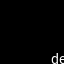

In [33]:
cuda = True if torch.cuda.is_available() else False

class Paste2dMask(nn.Module):
    def __init__(self, im_size):
        super(Paste2dMask, self).__init__()
        self.model = nn.Sequential(nn.Linear(1, 2), nn.Sigmoid())
        self.criterion = torch.nn.MSELoss()
        self.im_size = im_size

    def loss(self, y, x1, x2, gt):
        loss_restore = self.criterion(y, gt)
        loss_coord = torch.mean(F.relu(-(x2 - x1 - 1.0)))
        loss = loss_restore + loss_coord
        return loss

    def forward(self, x):
        l = self.im_size
        N = x.shape[0]

        x0 = x[:, 0].view(-1, 1) * l - 1.0
        y0 = x[:, 1].view(-1, 1) * l - 1.0
        x1 = x[:, 2].view(-1, 1) * l + 1.0
        y1 = x[:, 3].view(-1, 1) * l + 1.0

        coord = torch.arange(l).expand(N, -1).float()
        if cuda:
            coord = coord.cuda()

        _x0 = F.relu6((coord - x0) * 6.0)
        _x1 = F.relu6((x1 - coord) * 6.0)
        x_mask = (_x0 * _x1) / 36  # normalize again after relu6 (multiply by 6.)
        x_mask = x_mask.view(N, 1, l)

        _y0 = F.relu6((coord - y0) * 6.0)
        _y1 = F.relu6((y1 - coord) * 6.0)
        y_mask = (_y0 * _y1) / 36  # normalize again after relu6 (multiply by 6.)
        y_mask = y_mask.view(N, l, 1)  # align to y-axis

        mask = torch.ones(N, l, l)
        if cuda:
            mask = mask.cuda()
        mask = mask * x_mask * y_mask
        return mask.view(-1, 1, l, l)
    
class Paste2dMulti(nn.Module):
    def __init__(self, im_size, num_images):
        super(Paste2dMulti, self).__init__()
        self.im_size = im_size
        self.paste2dMask = Paste2dMask(im_size)
        self.num_images = num_images
    
    def _paste(self, coord):
        w = torch.Tensor([[self.im_size]]).float().expand(coord.shape[0],4)
        coord = torch.round(w * coord)
        ims = []
        for i, _coord in enumerate(coord):
            x0, y0, x1, y1 = _coord[0:4]
            ims.append(F.pad(image[i], (x0,y0,3,4), "constant", 0))
        return F.pad(input, (1,2,3,4), "constant", 0)

    def _pad_image(self, coord, image):
        """
        Arguments:
            coord: (N, 4=(x0, y0, x1, y1))
            image: (N, C, H, W)
        Return:
            Tensor (N, C, self.im_size, self.im_size), padded image
        """
        print(coord)
        N, C, H, W = image.shape
        y = []
        for _coord, _im in zip(coord, image):
            f = lambda i: int(_coord[i].item())
            x0, y0, _, _  = f(0), f(1), f(2), f(3)  # lost gradient
            x1, y1 = x0+W, y0+H
            if any([x0 >= x1, y0 >= y1, x0 > self.im_size, x1 < 1, y0 > self.im_size, y1 < 1]):
                # null mask
                y.append(torch.zeros(_im.shape[0], self.im_size, self.im_size).type(_im.type()))
            else:
                y.append(
                    F.pad(
                        _im,
                        (x0, self.im_size - x1, y0, self.im_size - y1),
                        "constant",
                        0,
                    )
                )
        return torch.cat(y, dim=0)
    
    def forward(self, coords, images):
        """
        Arguments:
            coords: (N, num_images, 4=(x0, y0, x1, y1))
            images: (N, num_images, C, H, W)
        """
        y = []
        for _coord, _im in zip(coords.split(1, dim=1), images.split(1, dim=1)):
            _coord = _coord.squeeze(1)  # (N, 4)
            _im = _im.squeeze(1)  # (N, C, H, W)
            _im = self._pad_image(_coord, _im)  # (N, C, self.im_size, self.im_size)
            mask = self.paste2dMask(_coord / self.im_size)  # (N, C, self.im_size, self.im_size)
            _im = mask * _im
            y.append(_im)
        y = torch.cat(y, 1).sum(1, True)  # TODO: change to alpha blending
        y = torch.min(torch.ones(*y.shape), y)
        return y


class PasteLine(nn.Module):
    def __init__(self, im_size, max_chars):
        super(PasteLine, self).__init__()
        self.im_size = im_size
        self.max_chars = max_chars
        self.paste2dMulti = Paste2dMulti(im_size, max_chars)

    def forward(self, coord, chars, char_sizes):
        """
        Args:
            coord: (N, 2=(x0, y0)), coordinate for the line
            chars: (N, num_chars, C, H, W)
            char_sizes: (N, num_chars, 2=(char_w, char_h))
        """
        coord = coord * self.im_size # relative coords [0..1] to absoluate coord
        coord = coord.unsqueeze(1)
        coords = []  # (N, num_chars, 4=(x0, y0, x1, y1))
        for size in char_sizes.split(1, dim=1):
            coords.append(torch.cat((coord, coord + size), dim=2))
            coord = coord + size * torch.tensor([[[1, 0]]]).float()  # (x0 += w, y0)
        coords = torch.cat(coords, dim=1)
        return self.paste2dMulti(coords, chars)
    
def to_char_images(text, font='/notebooks/post-generator/asset/fonts_en/Roboto/Roboto-Regular.ttf', font_size=14, out_size=14):
    font = ImageFont.truetype(font, font_size)
    transform = transforms.ToTensor()
    chars, sizes = [], []
    for c in text:
        size = font.getsize(c)
        im = Image.new("L", (out_size, out_size))
        draw = ImageDraw.Draw(im)
        draw.text((0, 0), c, font=font, fill=255)
        chars.append(transform(im).unsqueeze(0))
        sizes.append(torch.Tensor(size).view(1, 2))
    return torch.cat(chars), torch.cat(sizes)


chars, sizes = to_char_images('deijf')
chars = chars.unsqueeze(0)
sizes = sizes.unsqueeze(0)

# print(ims.shape, sizes.shape)
m = PasteLine(64, 4)
y = m(torch.Tensor([[0.8, 0.8]]), chars, sizes)

transform = transforms.ToPILImage()
transform(y[0])

In [ ]:
# Text-to-line-image through neural network and keeps gradient
# 1. text to char images
# 2. paste char images as a single line

class Paste2d(nn.Module):
    def __init__(self, im_size):
        super(Paste2d, self).__init__()
        self.model = nn.Sequential(nn.Linear(1, 2), nn.Sigmoid())
        self.criterion = torch.nn.MSELoss()
        self.im_size = im_size

    def loss(self, y, x1, x2, gt):
        loss_restore = self.criterion(y, gt)
        loss_coord = torch.mean(F.relu(-(x2 - x1 - 1.0)))
        loss = loss_restore + loss_coord
        return loss

    def forward(self, x):
        l = self.im_size
        N = x.shape[0]

        x0 = x[:, 0].view(-1, 1) * l - 1.0
        y0 = x[:, 1].view(-1, 1) * l - 1.0
        x1 = x[:, 2].view(-1, 1) * l + 1.0
        y1 = x[:, 3].view(-1, 1) * l + 1.0

        coord = torch.arange(l).expand(N, -1).float()
        if cuda:
            coord = coord.cuda()

        _x0 = F.relu6((coord - x0) * 6.0)
        _x1 = F.relu6((x1 - coord) * 6.0)
        x_mask = (_x0 * _x1) / 36  # normalize again after relu6 (multiply by 6.)
        x_mask = x_mask.view(N, 1, l)

        _y0 = F.relu6((coord - y0) * 6.0)
        _y1 = F.relu6((y1 - coord) * 6.0)
        y_mask = (_y0 * _y1) / 36  # normalize again after relu6 (multiply by 6.)
        y_mask = y_mask.view(N, l, 1)  # align to y-axis

        mask = torch.ones(N, l, l)
        if cuda:
            mask = mask.cuda()
        mask = mask * x_mask * y_mask
        return mask.view(-1, 1, l, l)


class PasteLine(nn.Module):
    def __init__(self, im_size):
        super(PasteLine, self).__init__()
        self.n_chars = 10

    def forward(self, x):
        N = x.shape[0]
        for _x0 in x:
            
        return mask.view(-1, 1, l, l)

    
text = 'this is a test'
char_ims = [char_im(c) for c in text]

m = PasteLine()
y = m(char_ims)

In [2]:
class Paste2d(nn.Module):
    def __init__(self, im_size):
        super(Paste2d, self).__init__()
        self.model = nn.Sequential(nn.Linear(1, 2), nn.Sigmoid())
        self.criterion = torch.nn.MSELoss()
        self.im_size = im_size

    def loss(self, y, x1, x2, gt):
        loss_restore = self.criterion(y, gt)
        loss_coord = torch.mean(F.relu(-(x2 - x1 - 1.0)))
        loss = loss_restore + loss_coord
        return loss

    def forward(self, x):
        l = self.im_size
        N = x.shape[0]

        x0 = x[:, 0].view(-1, 1) * l - 1.0
        y0 = x[:, 1].view(-1, 1) * l - 1.0
        x1 = x[:, 2].view(-1, 1) * l + 1.0
        y1 = x[:, 3].view(-1, 1) * l + 1.0
        
        coord = torch.arange(l).expand(N, -1).float()
        if cuda:
          coord = coord.cuda()
          
        _x0 = F.relu6((coord - x0) * 6.0)
        _x1 = F.relu6((x1 - coord) * 6.0)
        x_mask = (_x0 * _x1) / 36  # normalize again after relu6 (multiply by 6.)
        x_mask = x_mask.view(N, 1, l)
        
        _y0 = F.relu6((coord - y0) * 6.0)
        _y1 = F.relu6((y1 - coord) * 6.0)
        y_mask = (_y0 * _y1) / 36  # normalize again after relu6 (multiply by 6.)
        y_mask = y_mask.view(N, l, 1)  # align to y-axis
        
        mask = torch.ones(N,l,l)
        if cuda:
          mask = mask.cuda()
        mask = mask * x_mask * y_mask
        return mask.view(-1, 1, l, l)

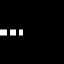

In [17]:
cuda = True if torch.cuda.is_available() else False
img_size = 64
painter = Paste2d(img_size)

def sample_text_layout(n_samples=100):
    w, h = img_size, img_size
    fake = Faker()

    def _sample_one(i):
        # sample text seed
        # textbox = (0, 0, fake.pyint(min_value=w*2/3, max_value=w, step=1))  # (x, y, w, h)
        token_h = 5
        textbox_wh = (w * 2 / 3, token_h)
        #     textbox_xy = (w - textbox_wh[0] / 2, h - textbox_wh[1] / 2)
        textbox_xy = (0, (h - textbox_wh[1]) / 2)
        n_tokens = fake.pyint(1, 3, 1)
        token_gap = fake.pyint(3, 5, 1)
        tokens_width = (fake.pyint(3, 6, 1) for _ in range(n_tokens))

        _x, _y = textbox_xy
        tokens_xywh = []
        for _w in tokens_width:
            tokens_xywh.append((_x, _y, _w, token_h))
            _x += _w + token_gap

        # render token boxes
        transform = transforms.ToPILImage()
        y = torch.zeros(1, 1, w, h)
        for _, (x0, y0, _w, _h) in enumerate(tokens_xywh):
            x1, y1 = x0 + _w, y0 + _h
            x = torch.tensor([[x0 / w, y0 / h, x1 / w, y1 / h]]).float()
            if cuda:
                x = x.cuda()
            _y = painter(x)
            y += _y.cpu()

        im = transform(y[0].cpu())
        return im
#         im.save("%s/%d.png" % (opt.data_path, i), "PNG")

    return _sample_one(0)
        
sample_text_layout(1)



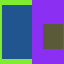

In [433]:
from enum import Enum
import random

fake = Faker()
# Brush = Enum('Brush', 'RECT PHOTO TEXT SPRITE')
Brush = Enum('Brush', 'RECT')

def paint(x, draw):
    x, y, w, h, r, g, b, brush = x
    x0, y0, x1, y1 = x, y, x+w, y+h

    if Brush(brush) == Brush.RECT:
        draw.rectangle((x0, y0, x1, y1), fill=(r, g, b))
#     elif brush == Brush.PHOTO:
#         pass
#     elif brush == Brush.TEXT:
#         pass
#     elif brush == Brush.SPRITE:
#         pass

def _sample_x(frame_xywh, xywh=None, brush=None, rgb=None,min_wh=(5, 5)):
    if xywh is None:
        w = fake.pyint(min_wh[0], frame_xywh[2])
        h = fake.pyint(min_wh[1], frame_xywh[3])
        x = fake.pyint(0, frame_xywh[2] - w) + frame_xywh[0]
        y = fake.pyint(0, frame_xywh[3] - h)+ frame_xywh[1]
        xywh = x, y, w, h
    if brush is None:
        brush = random.choice(list(Brush))
    if rgb is None:
        rgb = [int(x) for x in fake.rgb_color().split(",")]
    return (*xywh, *rgb, brush.value)
    
def cut(xywh, ratio=random.choice([1/6, 1/5, 1/4, 1/3, 1/2])):
    x, y, w, h = xywh
    r0 = random.choice([ratio, 1-ratio])
    w0 = int(w * ratio)
    w1 = w - w0
    xywh0 = (x, y, w0, h)
    xywh1 = (x+w0, y, w1, h)
    return xywh0, xywh1

# type(Brush.RECT.value)
# random.choice(list(Brush))

xs = []
for f in cut((0, 0, 64, 64)):
    xs += [_sample_x(f, xywh=f, brush=Brush.RECT), _sample_x(f)]  # bg, item
    
im = Image.new("RGB", (img_shape[1], img_shape[2]))
draw = ImageDraw.Draw(im)
for x in xs:
    paint(x, draw)
    
im

/notebooks/CoordConv-pytorch/experiments/gan/munit


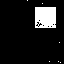

In [169]:
%cd /notebooks/CoordConv-pytorch/experiments/gan/munit

class Generator(nn.Module):
    def __init__(self, in_dim=100):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            # *block(in_dim, 128, normalize=False),
            nn.Linear(in_dim, 128),
            nn.Linear(128, 128),
            nn.Linear(128, 128),
            *block(128, 128, normalize=False),
            *block(128, 256, normalize=False),
            *block(256, 512, normalize=False),
            *block(512, 1024, normalize=False),
            nn.Linear(1024, int(np.prod(img_shape))),
            # nn.Tanh(),
            nn.Sigmoid(),
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

painter = Generator(in_dim=4)
painter.load_state_dict(torch.load('saved_models/95000.pt', map_location="cpu"))

transform = transforms.ToPILImage()
y = painter(torch.tensor([[0, 0, 0, 0]]).float())
transform(y[0])

In [52]:
m = nn.Sequential(nn.Linear(1, 2), nn.Sigmoid())
x = m(torch.rand(3, 1))
print(x)

x1 = x[:, 0].view(-1, 1)*5
x2 = x[:, 1].view(-1, 1)*5

_x1 = F.relu6((torch.arange(5).expand(3,-1).float()-x1) * 6)
_x2 = F.relu6((x2-torch.arange(5).float()) * 6)
print(_x1)
print(_x2)
y = _x1 * _x2
y = y / 36.
y
# y = y / 36.
# print(_x1)
# _x2 = F.relu6((x2-torch.arange(5).float()) * 6)
# print(_x2)
# y = _x1 * _x2
# y = y / 36.

# torch.arange(5).expand(3,-1).float()

tensor([[0.2728, 0.6679],
        [0.2252, 0.6757],
        [0.1806, 0.6840]], grad_fn=<SigmoidBackward>)
tensor([[0.0000, 0.0000, 3.8174, 6.0000, 6.0000],
        [0.0000, 0.0000, 5.2428, 6.0000, 6.0000],
        [0.0000, 0.5822, 6.0000, 6.0000, 6.0000]], grad_fn=<HardtanhBackward0>)
tensor([[6.0000, 6.0000, 6.0000, 2.0382, 0.0000],
        [6.0000, 6.0000, 6.0000, 2.2699, 0.0000],
        [6.0000, 6.0000, 6.0000, 2.5186, 0.0000]], grad_fn=<HardtanhBackward0>)


tensor([[0.0000, 0.0000, 0.6362, 0.3397, 0.0000],
        [0.0000, 0.0000, 0.8738, 0.3783, 0.0000],
        [0.0000, 0.0970, 1.0000, 0.4198, 0.0000]], grad_fn=<DivBackward0>)

In [282]:
# x = torch.tensor([2.1, 2.1, 2.1, 2.1, 2.1], requires_grad=True)
x1 = torch.tensor([0.1], requires_grad=True)
x2 = torch.tensor([3.1], requires_grad=True)
gt = torch.tensor([100.])

_x1 = F.relu6((torch.arange(5).float()-x1) * 6)
print(_x1)
_x2 = F.relu6((x2-torch.arange(5).float()) * 6)
print(_x2)
y = _x1 * _x2
y = y / 36.
# y = y - torch.tensor([1., 1., 2., 0, 0])
# y = y - torch.arange(5).float()
print(y)
# y = x * 100
# y = y * 100
# y = torch.arange(10).float() - y
# y = y.div(y + 1e-6)
# y = y / (y + .0001)
# y = y * y * y

loss = (y - gt).mean()
loss.backward()
print(y)
print(loss)
print(x1.grad)

tensor([0.0000, 5.4000, 6.0000, 6.0000, 6.0000], grad_fn=<HardtanhBackward0>)
tensor([6.0000, 6.0000, 6.0000, 0.6000, 0.0000], grad_fn=<HardtanhBackward0>)
tensor([0.0000, 0.9000, 1.0000, 0.1000, 0.0000], grad_fn=<DivBackward0>)
tensor([0.0000, 0.9000, 1.0000, 0.1000, 0.0000], grad_fn=<DivBackward0>)
tensor(-99.6000, grad_fn=<MeanBackward0>)
tensor([-0.2000])


In [112]:
fake = Faker()

img_size = 5
index = fake.pyint(min=0, max=img_size-1)
F.one_hot(torch.tensor(index), img_size)
torch.arange(0,img_size)

def sampler():
    x, y = [], []
    for i in range(img_size):
        x.append(torch.tensor(i))
        y.append(F.one_hot(torch.tensor(i),img_size))
    x = torch.stack(x).float()
    y = torch.stack(y).float()
    return x, y

sampler()



# a = torch.tensor([3.],  requires_grad=True)
# y = a.expand(int(a[0]))
# gt = torch.tensor([1., 1., 1.])

# b = torch.tensor([2., 2.],  requires_grad=True)
# (x > 1) & (x > 2)
# a = x.add(1e-8)
# a = x/x
# y = x2.sum()
# y.backward()
# print(x.grad)
# x

# c = torch.cat((a,b), 0)
# y = c.mean()
# loss = (gt - y).mean()
# loss.backward()

# print(y)
# print(loss)
# print(a.grad)

# y = a * 10
# y.backward()
# print(a.grad)


(tensor([0., 1., 2., 3., 4.]), tensor([[1., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.]]))

In [5]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img):
        # Concatenate image and condition image by channels to produce input
#         img_input = torch.cat((img_A, img_B), 1)
        return self.model(img)


d = Discriminator()

summary(d, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,088
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,200
    InstanceNorm2d-4          [-1, 128, 16, 16]               0
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,544
    InstanceNorm2d-7            [-1, 256, 8, 8]               0
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,664
   InstanceNorm2d-10            [-1, 512, 4, 4]               0
        LeakyReLU-11            [-1, 512, 4, 4]               0
        ZeroPad2d-12            [-1, 512, 5, 5]               0
           Conv2d-13              [-1, 1, 4, 4]           8,192
Total params: 2,762,688
Trainable param

In [28]:
import torchvision.transforms as transforms




def generate_real_samples(n_sample=100, save_path="data/layout/"):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    width, height = 28, 28
    fake = Faker()

    def _sample(save_path):
        n_circles = fake.pyint(min=1, max=3)
        radius = fake.pyint(min=2, max=5)
        space = fake.pyint(min=2, max=4)
        x0 = fake.pyint(min=0, max=width - 1 - (n_circles * (radius + space)))
        y0 = fake.pyint(min=0, max=height - 1 - radius)

        im = Image.new("L", (width, height))
        draw = ImageDraw.Draw(im)

        for _ in range(n_circles):
            draw.rectangle((x0, y0, x0 + radius, y0 + radius), fill=255)
            x0 += radius + space
#         plt.imshow(im)
#         im.save(save_path, "PNG")

    for i in range(n_sample):
        _sample(os.path.join(save_path, "%d.png" % (i)))

generate_real_samples(n_sample=1000)

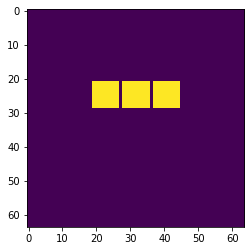

In [437]:
im = Image.open("data/0.png")
plt.imshow(np.array(im))
# im.mode

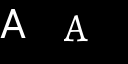

In [390]:
char = "A"
width = 64
fonts = ['/notebooks/post-generator/asset/fonts_en/Roboto/Roboto-Regular.ttf', 
            '/notebooks/post-generator/asset/fonts_en/Alegreya/Alegreya-Regular.ttf']

im = Image.new("RGB", (width * 2, width))

for i, fnt in enumerate(fonts):
    _im = Image.new("RGB", (width, width))
    _draw = ImageDraw.Draw(_im)
    _font = ImageFont.truetype(fnt, 40)
    _w, _h = _draw.textsize(char, _font)  # size of token
#     _draw.text(((width - _w) / 2, (width - _h) / 2), char, font=_font, fill=(255, 255, 255))
    _draw.text((0, 0), char, font=_font, fill=(255, 255, 255))
    im.paste(_im, (i * width, 0))
im

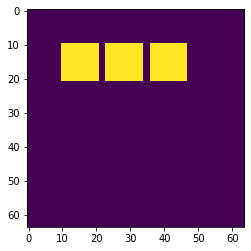

In [423]:
width, height = 64, 64
im = Image.new("L", (width, width))

draw = ImageDraw.Draw(im)
n_circles = 3
radius, space = 10, 3
x0, y0 = 10, 10
for i in range(n_circles):
#     draw.ellipse((x0, y0, x0+radius, y0+radius), fill=1)
    draw.rectangle((x0, y0, x0+radius, y0+radius), fill=1)
    x0 += radius + space
plt.imshow(np.array(im))

In [156]:


class Regressor(nn.Module):
    def __init__(self, in_channel, width, latent_size=256, n_class=3, bbox_size=4):
        super(Regressor, self).__init__()
        self.add_coords = AddCoords(rank=2)
        self.conv_class = nn.Sequential(
            nn.Conv2d(in_channel + 2, latent_size, 1, stride=1, padding=0),
            nn.BatchNorm2d(latent_size),
            nn.ReLU(),
            nn.Conv2d(latent_size, latent_size, 1, stride=1, padding=0),
            nn.BatchNorm2d(latent_size),
            nn.ReLU(),
            # nn.Conv2d(latent_size, n_class, 1, stride=1, padding=0),
            # nn.Linear(latent_size, n_class, 1, stride=1, padding=0),
        )
        self.conv_bbox = nn.Sequential(
            nn.Conv2d(in_channel + 2, latent_size, 1, stride=1, padding=0),
            nn.BatchNorm2d(latent_size),
            nn.ReLU(),
            nn.Conv2d(latent_size, latent_size, 1, stride=1, padding=0),
            nn.BatchNorm2d(latent_size),
            nn.ReLU(),
            # nn.Conv2d(latent_size, bbox_dim, 1, stride=1, padding=0),
        )
        self.fc_class = nn.Linear((width ** 2) * latent_size, n_class)
        self.fc_bbox = nn.Linear((width ** 2) * latent_size, bbox_size)

    def forward(self, x):
        N = x.shape[0]
        x = self.add_coords(x)
        x_class = self.conv_class(x)
        x_class = x_class.view(N, -1)
        x_class = self.fc_class(x_class)
        x_bbox = self.conv_bbox(x)
        x_bbox = x_bbox.view(N, -1)
        x_bbox = self.fc_bbox(x_bbox)
        return x_class, x_bbox
    
m = Regressor(in_channel=20, width=16)
summary(m, (20, 16, 16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AddCoords-1           [-1, 22, 16, 16]               0
            Conv2d-2          [-1, 256, 16, 16]           5,888
       BatchNorm2d-3          [-1, 256, 16, 16]             512
              ReLU-4          [-1, 256, 16, 16]               0
            Conv2d-5          [-1, 256, 16, 16]          65,792
       BatchNorm2d-6          [-1, 256, 16, 16]             512
              ReLU-7          [-1, 256, 16, 16]               0
            Linear-8                    [-1, 3]         196,611
            Conv2d-9          [-1, 256, 16, 16]           5,888
      BatchNorm2d-10          [-1, 256, 16, 16]             512
             ReLU-11          [-1, 256, 16, 16]               0
           Conv2d-12          [-1, 256, 16, 16]          65,792
      BatchNorm2d-13          [-1, 256, 16, 16]             512
             ReLU-14          [-1, 256,

In [8]:
class HRNet(nn.Module):
    def __init__(self, width):
        super(HRNet, self).__init__()
        cfg = get_cfg_defaults()
        cfg.merge_from_file("./exp.yaml")
        self.hr = HighResolutionNet(cfg)
        self.add_coords = AddCoords(rank=2)
        self.conv5 = nn.Conv2d(7, 7, 3, padding=1)
        self.conv6 = nn.Conv2d(7, 7, 3, padding=1)
        self.conv7 = nn.Conv2d(7, 4, 1)
        self.pool = nn.MaxPool2d(width, stride=width)

    def forward(self, x):
        x1 = self.hr(x)
        x1 = F.interpolate(x1, scale_factor=4)
        x = torch.cat((x, x1), dim=1)
        x = self.add_coords(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.conv7(x)
        x = self.pool(x)
        x = x.view(-1, 4)
        return x
m = HRNet(width=64)
# summary(m, (3, 64, 64))
x = m(torch.rand(1,1,64,64))
x.shape

torch.Size([1, 4])

In [2]:
# from models.CornerNet import model

# m = model()

class convolution(nn.Module):
    def __init__(self, k, inp_dim, out_dim, stride=1, with_bn=True):
        super(convolution, self).__init__()

        pad = (k - 1) // 2
        self.conv = nn.Conv2d(inp_dim, out_dim, (k, k), padding=(pad, pad), stride=(stride, stride), bias=not with_bn)
        self.bn   = nn.BatchNorm2d(out_dim) if with_bn else nn.Sequential()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.conv(x)
        bn   = self.bn(conv)
        relu = self.relu(bn)
        return relu

class residual(nn.Module):
    def __init__(self, inp_dim, out_dim, k=3, stride=1):
        super(residual, self).__init__()
        p = (k - 1) // 2

        self.conv1 = nn.Conv2d(inp_dim, out_dim, (k, k), padding=(p, p), stride=(stride, stride), bias=False)
        self.bn1   = nn.BatchNorm2d(out_dim)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_dim, out_dim, (k, k), padding=(p, p), bias=False)
        self.bn2   = nn.BatchNorm2d(out_dim)
        
        self.skip  = nn.Sequential(
            nn.Conv2d(inp_dim, out_dim, (1, 1), stride=(stride, stride), bias=False),
            nn.BatchNorm2d(out_dim)
        ) if stride != 1 or inp_dim != out_dim else nn.Sequential()
        self.relu  = nn.ReLU(inplace=True)

    def forward(self, x):
        conv1 = self.conv1(x)
        bn1   = self.bn1(conv1)
        relu1 = self.relu1(bn1)

        conv2 = self.conv2(relu1)
        bn2   = self.bn2(conv2)

        skip  = self.skip(x)
        return self.relu(bn2 + skip)


pre = nn.Sequential(
            convolution(7, 3, 128, stride=2), residual(128, 256, stride=2)
        )
# pre(torch.from_numpy(np.random.rand(1, 3, 128, 128)).double())
# conv = convolution(7, 3, 128, stride=2)
x = torch.rand(1, 3, 512, 512)
x = pre(x)
# x.shape

summary(pre, (3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 200, 200]          18,816
       BatchNorm2d-2        [-1, 128, 200, 200]             256
              ReLU-3        [-1, 128, 200, 200]               0
       convolution-4        [-1, 128, 200, 200]               0
            Conv2d-5        [-1, 256, 100, 100]         294,912
       BatchNorm2d-6        [-1, 256, 100, 100]             512
              ReLU-7        [-1, 256, 100, 100]               0
            Conv2d-8        [-1, 256, 100, 100]         589,824
       BatchNorm2d-9        [-1, 256, 100, 100]             512
           Conv2d-10        [-1, 256, 100, 100]          32,768
      BatchNorm2d-11        [-1, 256, 100, 100]             512
             ReLU-12        [-1, 256, 100, 100]               0
         residual-13        [-1, 256, 100, 100]               0
Total params: 938,112
Trainable params:

In [3]:
class upsample(nn.Module):
    def __init__(self, scale_factor):
        super(upsample, self).__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return nn.functional.interpolate(x, scale_factor=self.scale_factor)

class merge(nn.Module):
    def forward(self, x, y):
        return x + y
    
def _make_layer(inp_dim, out_dim, modules):
    layers  = [residual(inp_dim, out_dim)]
    layers += [residual(out_dim, out_dim) for _ in range(1, modules)]
    return nn.Sequential(*layers)

def _make_layer_revr(inp_dim, out_dim, modules):
    layers  = [residual(inp_dim, inp_dim) for _ in range(modules - 1)]
    layers += [residual(inp_dim, out_dim)]
    return nn.Sequential(*layers)

def _make_pool_layer(dim):
    return nn.MaxPool2d(kernel_size=2, stride=2)

def _make_unpool_layer(dim):
    return upsample(scale_factor=2)

def _make_merge_layer(dim):
    return merge()

class fire_module(nn.Module):
    def __init__(self, inp_dim, out_dim, sr=2, stride=1):
        super(fire_module, self).__init__()
        self.conv1    = nn.Conv2d(inp_dim, out_dim // sr, kernel_size=1, stride=1, bias=False)
        self.bn1      = nn.BatchNorm2d(out_dim // sr)
        self.conv_1x1 = nn.Conv2d(out_dim // sr, out_dim // 2, kernel_size=1, stride=stride, bias=False)
        self.conv_3x3 = nn.Conv2d(out_dim // sr, out_dim // 2, kernel_size=3, padding=1, 
                                  stride=stride, groups=out_dim // sr, bias=False)
        self.bn2      = nn.BatchNorm2d(out_dim)
        self.skip     = (stride == 1 and inp_dim == out_dim)
        self.relu     = nn.ReLU(inplace=True)

    def forward(self, x):
        conv1 = self.conv1(x)
        bn1   = self.bn1(conv1)
        conv2 = torch.cat((self.conv_1x1(bn1), self.conv_3x3(bn1)), 1)
        bn2   = self.bn2(conv2)
        if self.skip:
            return self.relu(bn2 + x)
        else:
            return self.relu(bn2)

class hg_module(nn.Module):
    def __init__(
        self, n, dims, modules, make_up_layer=_make_layer,
        make_pool_layer=_make_pool_layer, make_hg_layer=_make_layer,
        make_low_layer=_make_layer, make_hg_layer_revr=_make_layer_revr,
        make_unpool_layer=_make_unpool_layer, make_merge_layer=_make_merge_layer
    ):
        super(hg_module, self).__init__()

        curr_mod = modules[0]
        next_mod = modules[1]

        curr_dim = dims[0]
        next_dim = dims[1]

        self.n    = n
        self.up1  = make_up_layer(curr_dim, curr_dim, curr_mod)
        self.max1 = make_pool_layer(curr_dim)
        self.low1 = make_hg_layer(curr_dim, next_dim, curr_mod)
        self.low2 = hg_module(
            n - 1, dims[1:], modules[1:],
            make_up_layer=make_up_layer,
            make_pool_layer=make_pool_layer,
            make_hg_layer=make_hg_layer,
            make_low_layer=make_low_layer,
            make_hg_layer_revr=make_hg_layer_revr,
            make_unpool_layer=make_unpool_layer,
            make_merge_layer=make_merge_layer
        ) if n > 1 else make_low_layer(next_dim, next_dim, next_mod)
        self.low3 = make_hg_layer_revr(next_dim, curr_dim, curr_mod)
        self.up2  = make_unpool_layer(curr_dim)
        self.merg = make_merge_layer(curr_dim)

    def forward(self, x):
        up1  = self.up1(x)
        max1 = self.max1(x)
        low1 = self.low1(max1)
        low2 = self.low2(low1)
        low3 = self.low3(low2)
        up2  = self.up2(low3)
        print(up1.shape)
        print(up2.shape)
        merg = self.merg(up1, up2)
        return merg
#         return up1

    
def make_pool_layer(dim):
    return nn.Sequential()

def make_unpool_layer(dim):
    return nn.ConvTranspose2d(dim, dim, kernel_size=4, stride=2, padding=1)

def make_layer(inp_dim, out_dim, modules):
    layers  = [fire_module(inp_dim, out_dim)]
    layers += [fire_module(out_dim, out_dim) for _ in range(1, modules)]
    return nn.Sequential(*layers)

def make_layer_revr(inp_dim, out_dim, modules):
    layers  = [fire_module(inp_dim, inp_dim) for _ in range(modules - 1)]
    layers += [fire_module(inp_dim, out_dim)]
    return nn.Sequential(*layers)

def make_hg_layer(inp_dim, out_dim, modules):
    layers  = [fire_module(inp_dim, out_dim, stride=2)]
    layers += [fire_module(out_dim, out_dim) for _ in range(1, modules)]
    return nn.Sequential(*layers)

m = hg_module(
                4, [256, 256, 384, 384, 512], [2, 2, 2, 2, 4],
                make_pool_layer=make_pool_layer,
                make_unpool_layer=make_unpool_layer,
                make_up_layer=make_layer,
                make_low_layer=make_layer,
                make_hg_layer_revr=make_layer_revr,
                make_hg_layer=make_hg_layer
            )

summary(m, (256, 256, 256))
# m(torch.rand(1, 256, 100, 100))

torch.Size([2, 384, 32, 32])
torch.Size([2, 384, 32, 32])
torch.Size([2, 384, 64, 64])
torch.Size([2, 384, 64, 64])
torch.Size([2, 256, 128, 128])
torch.Size([2, 256, 128, 128])
torch.Size([2, 256, 256, 256])
torch.Size([2, 256, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 256, 256]          32,768
       BatchNorm2d-2        [-1, 128, 256, 256]             256
            Conv2d-3        [-1, 128, 256, 256]          16,384
            Conv2d-4        [-1, 128, 256, 256]           1,152
       BatchNorm2d-5        [-1, 256, 256, 256]             512
              ReLU-6        [-1, 256, 256, 256]               0
       fire_module-7        [-1, 256, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]          32,768
       BatchNorm2d-9        [-1, 128, 256, 256]             256
           Conv2d-10        [-1, 128, 256, 256]        

In [5]:
def _pred_mod(dim):
        return nn.Sequential(
            convolution(1, 256, 256, with_bn=False),
            nn.Conv2d(256, dim, (1, 1))
        )
m = _pred_mod(80)
summary(m, (256, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 200, 200]          65,792
              ReLU-2        [-1, 256, 200, 200]               0
       convolution-3        [-1, 256, 200, 200]               0
            Conv2d-4         [-1, 80, 200, 200]          20,560
Total params: 86,352
Trainable params: 86,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 39.06
Forward/backward pass size (MB): 258.79
Params size (MB): 0.33
Estimated Total Size (MB): 298.18
----------------------------------------------------------------


In [10]:
from models.py_utils import TopPool, LeftPool

class corner_pool(nn.Module):
    def __init__(self, dim, pool1, pool2):
        super(corner_pool, self).__init__()
        self._init_layers(dim, pool1, pool2)

    def _init_layers(self, dim, pool1, pool2):
        self.p1_conv1 = convolution(3, dim, 128)
        self.p2_conv1 = convolution(3, dim, 128)

        self.p_conv1 = nn.Conv2d(128, dim, (3, 3), padding=(1, 1), bias=False)
        self.p_bn1   = nn.BatchNorm2d(dim)

        self.conv1 = nn.Conv2d(dim, dim, (1, 1), bias=False)
        self.bn1   = nn.BatchNorm2d(dim)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = convolution(3, dim, dim)

        self.pool1 = pool1()
        self.pool2 = pool2()

    def forward(self, x):
        # pool 1
        p1_conv1 = self.p1_conv1(x)
        pool1    = self.pool1(p1_conv1)

        # pool 2
        p2_conv1 = self.p2_conv1(x)
        pool2    = self.pool2(p2_conv1)

        # pool 1 + pool 2
        p_conv1 = self.p_conv1(pool1 + pool2)
        p_bn1   = self.p_bn1(p_conv1)

        conv1 = self.conv1(x)
        bn1   = self.bn1(conv1)
        relu1 = self.relu1(p_bn1 + bn1)

        conv2 = self.conv2(relu1)
        return conv2

m = corner_pool(256, TopPool, LeftPool)
summary(m, (256, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 100, 100]         294,912
       BatchNorm2d-2        [-1, 128, 100, 100]             256
              ReLU-3        [-1, 128, 100, 100]               0
       convolution-4        [-1, 128, 100, 100]               0
           TopPool-5        [-1, 128, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]         294,912
       BatchNorm2d-7        [-1, 128, 100, 100]             256
              ReLU-8        [-1, 128, 100, 100]               0
       convolution-9        [-1, 128, 100, 100]               0
         LeftPool-10        [-1, 128, 100, 100]               0
           Conv2d-11        [-1, 256, 100, 100]         294,912
      BatchNorm2d-12        [-1, 256, 100, 100]             512
           Conv2d-13        [-1, 256, 100, 100]          65,536
      BatchNorm2d-14        [-1, 256, 1

In [13]:
class SimpleNet(nn.Module):
    def __init__(self, width):
        super(SimpleNet, self).__init__()
        self.width = width
        self.add_coords = AddCoords(rank=2)
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = corner_pool(32, TopPool, LeftPool)
        self.conv4 = nn.Conv2d(32, 1, 1)
        self.conv5 = nn.Conv2d(1, 1, 1)

    def forward(self, x):
        # x: (N, C_in, H, W)
        x = self.add_coords(x)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.conv5(x)
        return x

m = SimpleNet(width=3)
summary(m, (1, 3, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AddCoords-1              [-1, 3, 3, 3]               0
            Conv2d-2              [-1, 8, 3, 3]             224
            Conv2d-3             [-1, 16, 3, 3]           1,168
            Conv2d-4             [-1, 32, 3, 3]           4,640
            Conv2d-5            [-1, 128, 3, 3]          36,864
       BatchNorm2d-6            [-1, 128, 3, 3]             256
              ReLU-7            [-1, 128, 3, 3]               0
       convolution-8            [-1, 128, 3, 3]               0
           TopPool-9            [-1, 128, 3, 3]               0
           Conv2d-10            [-1, 128, 3, 3]          36,864
      BatchNorm2d-11            [-1, 128, 3, 3]             256
             ReLU-12            [-1, 128, 3, 3]               0
      convolution-13            [-1, 128, 3, 3]               0
         LeftPool-14            [-1, 12

In [102]:
import itertools

# def norm(x, width):
#     return x * width

def norm(x, width):
    return (int)(x * (width - 1) + 0.5)

def _draw_rect(points, width=64):
    x0, y0, x1, y1 = points
    print(x0, y0, x1, y1)
    x0 = norm(x0, width)
    y0 = norm(y0, width)
    x1 = norm(x1, width)
    y1 = norm(y1, width)
#     if (x1 == 1):
#         x1 -= 0.1
#     if (y1 == 1):
#         y1 -= 0.1
    print(x0, y0, x1, y1)
    im = Image.new("F", (width, width))
    draw = ImageDraw.Draw(im)
    draw.rectangle([x0, y0, x1, y1], fill=1, outline=None, width=0)
    im = np.array(im)  # (H, W)
    print(im)
    im = np.expand_dims(im, axis=-1)  # (H, W, 1)
    return im

def draw_rect(xy, width=3):
    x0, y0, x1, y1 = xy
    rect = np.zeros()
    

width = 3
xy = []
for x0, y0 in itertools.product(range(width), range(width)):
    for _w, _h in itertools.product(range(1, width - x0 + 1), range(1, width-y0+1)):
        x1 = x0 + _w
        y1 = y0 + _h
        xy.append([x0, y0, x1, y1])
#         x = np.array([x0, y0, x1, y1], dtype=float)
#         x /= width
#         draw_rect(x, width)
        
for (x0, y0, x1, y1) in xy:
    rect = np.zeros((width, width))
    for i, j in itertools.product(range(x0, x1), range(y0, y1)):
        rect[i][j] = 1.
#     print(rect)

# x = np.array([1,2], dtype=int)
# x = x.astype(float) / 2
x = np.stack([np.array([1,2]), np.array([3,4]), np.array([3,4])])
len(x)

def draw_l2_distance(x, y, width=64):
    im = np.zeros((width, width), dtype=float)
    for (i, j), _ in np.ndenumerate(im):
        im[i][j] = -np.linalg.norm(np.array([x, y]) - np.array([i, j])) / width
#     im = im.transpose(1, 0).reshape(width * width)  # (W, H) -> (H, W) -> (H*W)
    return im

draw_l2_distance(1, 2, width=3)

array([[-0.74535599, -0.47140452, -0.33333333],
       [-0.66666667, -0.33333333, -0.        ],
       [-0.74535599, -0.47140452, -0.33333333]])

In [120]:
x0 = torch.rand(1,3,100, 100)
m = nn.MaxPool2d(2)
x1 = m(x0)
x1 = F.interpolate(x1, scale_factor=2)
# x = torch.cat((x0, x1), dim=1)
x.shape

torch.Size([1, 6, 100, 100])

Generating datasets...
2
2


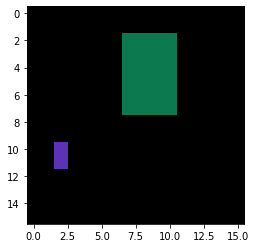

In [108]:
def draw_rect_pil(xy, width=64):
    x0, y0, x1, y1 = xy
    x1 -= 0.5
    y1 -= 0.5
    im = Image.new("F", (width, width))
    draw = ImageDraw.Draw(im)
    draw.rectangle([x0, y0, x1, y1], fill=1)
    im = np.array(im)  # (H, W)
    return im


def rand_draw(draw_fn=draw_rect_pil, n_strokes=2, width=64):
    canvas = np.zeros((width, width, 3), dtype=np.int8)
    im = [canvas.copy()]
    x = []
    for _ in range(n_strokes):
        x0, y0 = np.random.randint(width, size=2)
        x1 = x0 + np.random.randint(1, width - x0 + 1)
        y1 = y0 + np.random.randint(1, width - y0 + 1)
        _x = np.array((x0, y0, x1, y1))
        #         _x = np.random.rand(action_dim)
        color = np.random.randint(255, size=(3))  # (3)
        #         x.append(np.concatenate((_x, color / 255.0)))
        stroke = draw_fn(_x, width)  # (w, w)
        stroke = np.expand_dims(stroke, axis=2)  # (w, w, 1)
        canvas = canvas * (1 - stroke) + stroke * color  # (w, h, 3)
        x.append(_x)
        im.append(canvas.copy())
    x = np.stack(x) / width  # (n_strokes, action_dim+3)
    im = np.stack(im)
    return x, im

def generate_data(width=128, n_sample=1000, n_strokes=2):
    print("Generating datasets...")
    if not os.path.exists("data-rect/"):
        os.makedirs("data-rect/")

    x, im = [], []
    for _ in range(n_sample):
        _x, _im = rand_draw(n_strokes=n_strokes, width=width)
        _im_inter = _im[:-1]
        _im_target = _im[-1]
#         print(_im_inter.shape)
        for i in range(n_strokes):
            im.append(np.concatenate((_im_inter[i], _im_target), axis=2))
            x.append(_x[i])
    print(len(x))
    print(len(im))
#     print(im[0][:,:,-3:])
#     plt.imshow(Image.fromarray(im[1][:,:,:-3].astype('uint8')))
    plt.imshow(Image.fromarray(im[1][:,:,-3:].astype('uint8')))

generate_data(width=16, n_sample=1, n_strokes=2)
# a = np.array([1,2,3])
# a = np.random.rand(5,3)
# b = np.array([3,4,5])
# b = np.random.rand(5,3)
# np.concatenate([a,b],axis=1).shape
# x[:-1]

# x, im = rand_draw()
# fig, ax = plt.subplots(1,3)
# ax[0].imshow(Image.fromarray(im[0].astype(np.uint8)))
# ax[1].imshow(Image.fromarray(im[1].astype(np.uint8)))
# ax[2].imshow(Image.fromarray(im[2].astype(np.uint8)))
# fig.show()



In [13]:
class Regressor(nn.Module):
    def __init__(self, in_channel, width, out_size=4, latent_size=128):
        super(Regressor, self).__init__()
        self.add_coords = AddCoords(rank=2)
#         self.conv0 = nn.Conv2d(in_channel + 2, latent_size, 3, padding=1)
#         self.bn0 = BatchNorm2d(latent_size)
#         self.conv1 = nn.Conv2d(latent_size, latent_size, 3, padding=1)
#         self.bn1 = BatchNorm2d(latent_size)
# self.conv2 = nn.Conv2d(latent_size, out_size, 1)
        self.conv0 = nn.Conv2d(in_channel + 2, latent_size, 1, stride=1, padding=0)
        self.bn0 = nn.BatchNorm2d(latent_size)
        self.conv2 = nn.Conv2d(latent_size, out_size, 1, stride=1, padding=0)
        self.pool = nn.MaxPool2d(width, stride=width)

    def forward(self, x):
        x = self.add_coords(x)
        x = self.conv0(x)
        x = F.relu(self.bn0(x))
#         x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.pool(x)
        x = x.view(-1, 4)
        return x
    
class HRNet(nn.Module):
    def __init__(self, width):
        super(HRNet, self).__init__()
        cfg = get_cfg_defaults()
        cfg.merge_from_file("./hrnet.yaml")
        self.hr0 = HighResolutionNet(cfg)
        self.hr1 = HighResolutionNet(cfg)
        self.rg = Regressor(in_channel=540, width=int(width/4))
        
    def forward(self, im_current, im_target):
        x0 = self.hr0(im_current)
        x1 = self.hr1(im_target)
        x = torch.cat((x0, x1), dim=1)
        x = self.rg(x)
        return x

class Painter(nn.Module):
    def __init__(self, in_dim=128, out_dim=4, hidden_dim=128):
        super(Painter, self).__init__()
        self.lstm = nn.LSTM(in_dim, hidden_dim)
        self.fc0 = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        return x

    
m = HRNet(64)
x0 = torch.rand(1,3,64,64)
x1 = torch.rand(1,3,64,64)
m(x0, x1).shape

# summary(m, (1, 128))

# rnn = nn.GRU(10, 20)
# input = torch.randn(5, 3, 10)
# h0 = torch.randn(2, 3, 20)
# # output, hn = rnn(input, h0)
# output, hn = rnn(input)
# print(output.shape)
# print(hn.shape)


# summary(rnn, (3, 10))

torch.Size([1, 4])